In [1]:
import pandas as pd
import numpy as np
import pickle
import pyodbc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
import pyodbc
import pandas as pd

# 1. Connection details
server = '172.17.35.52'
database = 'AdventureWorks2022'
username = 'mlops'
password = 'mlops2k25'

# 2. Create connection
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
)

# 3. SQL query (avoid reserved words as column aliases)
query = """
SELECT
    ServerName AS [Server],
    DatabaseName AS [DatabaseName],
    RecordDate AS [Date],
    SizeMB
FROM dbo.database_info_tb
"""

# 4. Read into DataFrame
df = pd.read_sql(query, conn)

# 5. Close connection
conn.close()

# 6. Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# 7. Sort by Server, DatabaseName, Date
df = df.sort_values(["Server", "DatabaseName", "Date"])

print(df.head())


C:\Users\vpotla\AppData\Local\Temp\ipykernel_2300\2657453538.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


    Server DatabaseName       Date  SizeMB
0  Server1          DB1 2000-01-02  105.94
1  Server1          DB1 2000-01-03  118.67
2  Server1          DB1 2000-01-04  139.75
3  Server1          DB1 2000-01-05  155.52
4  Server1          DB1 2000-01-06  162.24


In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.SizeMB.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.494656
p-value: 0.000000


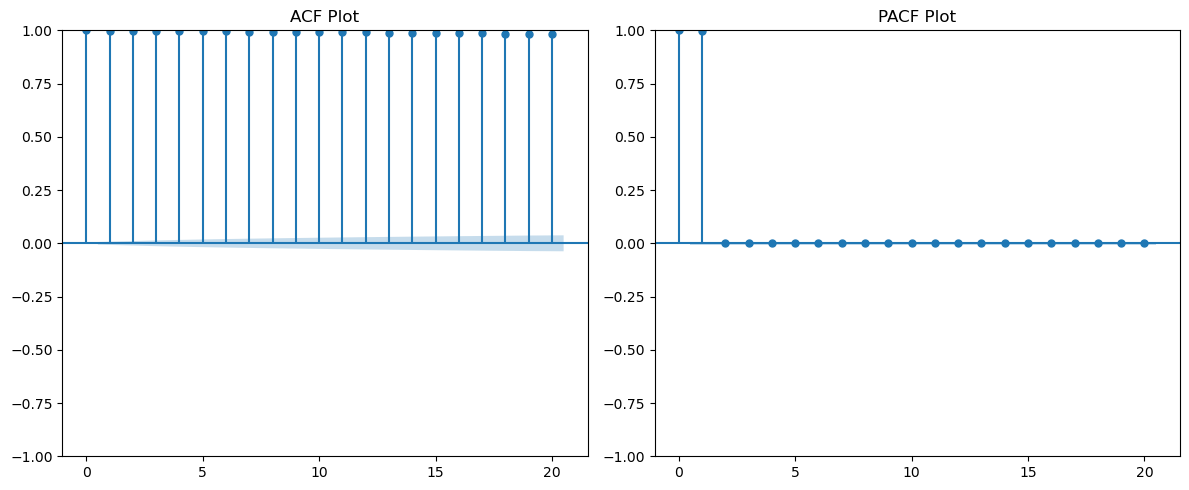

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example: df is your DataFrame, 'SizeMB' is the time series
series = df['SizeMB']

plt.figure(figsize=(12, 5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(series, lags=20, ax=plt.gca())
plt.title("ACF Plot")

# PACF
plt.subplot(1, 2, 2)
plot_pacf(series, lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF Plot")

plt.tight_layout()
plt.show()


In [21]:

def check_stationarity(ts):
    """Run Augmented Dickey-Fuller test to check stationarity."""
    result = adfuller(ts.dropna())
    adf_stat, p_value = result[0], result[1]
    print(adf_stat)
    print(p_value)
    return p_value <= 0.05  # True if stationary

In [5]:
def evaluate_forecast(actual, predicted):
    """Return RMSE, MAE, and MAPE for forecasts."""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

In [14]:
def train_and_evaluate(ts, order=(1,1,1), test_horizon=6):
    """Train ARIMA, forecast, and evaluate."""
    # Split train/test (time-aware)
    train, test = ts.iloc[:-test_horizon], ts.iloc[-test_horizon:]
    
    # Fit model
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=test_horizon)
    
    # Evaluate
    metrics = evaluate_forecast(test, forecast)
    
    return model_fit, forecast, test, metrics

In [22]:
# ------------------------------
# Main Training Script
# ------------------------------

# Load Data
df = pd.read_csv("db_growth_data.csv", parse_dates=["Date"])
df = preprocess_data(df)

models_bundle = {}

# Train a model for each (Server, Database)
for (server, db), group in df.groupby(["Server", "Database"]):
    # Resample monthly (take last value each month)
    monthly_data = group.resample("MS", on="Date")["DB_Size_GB"].last()
    ts = monthly_data.asfreq("MS").fillna(method="ffill")
    
    if len(ts) < 18:
        print(f"Skipping {server} - {db} (insufficient data)")
        continue
    
    # Check stationarity
    if check_stationarity(ts):
        d = 0
        print(f"{server} - {db}: Stationary (d=0)")
    else:
        d = 1
        print(f"{server} - {db}: Non-stationary (d=1 applied)")
    
    # Train & evaluate
    order = (2, 2, 1)
    fit, forecast, test, metrics = train_and_evaluate(ts, order=order, test_horizon=6)
    
    # Store in bundle
    models_bundle[(server, db)] = {
        "model": fit,
        "order": order,
        "metrics": metrics,
        "train_end": str(ts.index.max().date()),
        "freq": "MS"
    }
    
    print(f"{server}-{db} | RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE']:.2f}%")


C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")


-1.3254065409741036
0.6174701345444736
Server_A - DB_Analytics: Non-stationary (d=1 applied)
Server_A-DB_Analytics | RMSE: 8.42, MAE: 7.99, MAPE: 24.98%
-1.4120947493900349
0.5764642051815791
Server_A - DB_Finance: Non-stationary (d=1 applied)
Server_A-DB_Finance | RMSE: 5.54, MAE: 4.50, MAPE: 21.98%
-0.656536312714133
0.8576887841674363
Server_A - DB_HR: Non-stationary (d=1 applied)
Server_A-DB_HR | RMSE: 8.76, MAE: 7.77, MAPE: 25.37%
-0.5994380102094528
0.871108962981453
Server_A - DB_Inventory: Non-stationary (d=1 applied)
Server_A-DB_Inventory | RMSE: 6.36, MAE: 6.01, MAPE: 19.06%
0.6060564407026338
0.987763962563194
Server_A - DB_Sales: Non-stationary (d=1 applied)
Server_A-DB_Sales | RMSE: 4.27, MAE: 3.76, MAPE: 12.93%
-0.9362855838635388
0.7757883793993317
Server_B - DB_Analytics: Non-stationary (d=1 applied)


C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\Desktop\pvani\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(met

Server_B-DB_Analytics | RMSE: 6.52, MAE: 4.86, MAPE: 25.08%
-0.8801625828465964
0.7944349534320092
Server_B - DB_Finance: Non-stationary (d=1 applied)
Server_B-DB_Finance | RMSE: 5.38, MAE: 4.69, MAPE: 20.22%
-0.4814128232555691
0.8955929063139432
Server_B - DB_HR: Non-stationary (d=1 applied)
Server_B-DB_HR | RMSE: 6.38, MAE: 5.24, MAPE: 21.15%
-1.6834728553486111
0.439647243775737
Server_B - DB_Inventory: Non-stationary (d=1 applied)


C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\Desktop\pvani\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(met

Server_B-DB_Inventory | RMSE: 8.51, MAE: 6.62, MAPE: 23.31%
-2.448536509338408
0.1285031162410794
Server_B - DB_Sales: Non-stationary (d=1 applied)
Server_B-DB_Sales | RMSE: 4.98, MAE: 3.46, MAPE: 16.49%
-1.476949434614228
0.5448817534155088
Server_C - DB_Analytics: Non-stationary (d=1 applied)


C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\Desktop\pvani\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\vpotla\Desktop\pvani\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramete

Server_C-DB_Analytics | RMSE: 7.00, MAE: 5.44, MAPE: 17.43%
-0.3902970855398389
0.9117062550428141
Server_C - DB_Finance: Non-stationary (d=1 applied)
Server_C-DB_Finance | RMSE: 8.07, MAE: 6.45, MAPE: 21.58%
-1.8354800243632734
0.3629944820752691
Server_C - DB_HR: Non-stationary (d=1 applied)
Server_C-DB_HR | RMSE: 4.44, MAE: 3.40, MAPE: 13.13%
-1.1791908000459177
0.6824826438177788
Server_C - DB_Inventory: Non-stationary (d=1 applied)


C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\Desktop\pvani\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\vpotla\Desktop\pvani\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(metho

Server_C-DB_Inventory | RMSE: 9.13, MAE: 7.51, MAPE: 27.18%
-1.0575304972132553
0.7317078558291391
Server_C - DB_Sales: Non-stationary (d=1 applied)
Server_C-DB_Sales | RMSE: 6.13, MAE: 5.31, MAPE: 21.65%


C:\Users\vpotla\AppData\Local\Temp\ipykernel_14772\3201448558.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = monthly_data.asfreq("MS").fillna(method="ffill")
C:\Users\vpotla\Desktop\pvani\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:

# # Save models to pickle
# with open("arima_models.pkl", "wb") as f:
#     pickle.dump(models_bundle, f)

# print("✅ Models and metrics saved successfully!")